In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

df = pd.read_csv('../data/jan_data.csv')
df['time'] = pd.to_datetime(df['time'])

df.iloc[1800]['dollar_open_interest_close']

C:\Users\vosko\AppData\Local\Temp\ipykernel_23712\3452797966.py:6: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/jan_data.csv')


1875000776.354

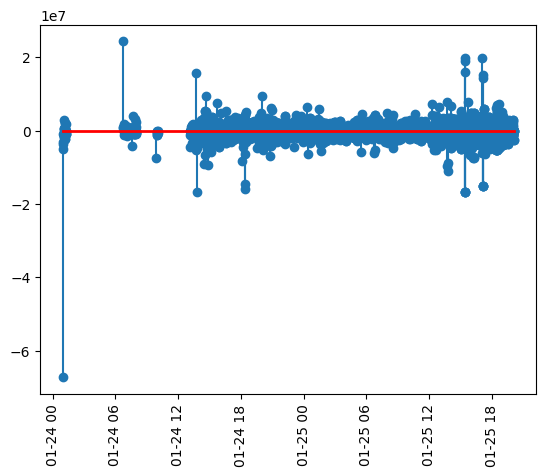

In [208]:

df['diff'] = df['dollar_open_interest_close'].diff()
df_jan2324 = df.loc[(df['time']>'2024-01-24')]
x = df_jan2324['time']
y = df_jan2324['diff']
plt.xticks(rotation=90)
markerline, stemlines, baseline  = plt.stem(x,y)
plt.setp(baseline, color='r', linewidth=2)

plt.show()


In [215]:
from scipy import stats
import math

df_slice = df_jan2324.loc[df_jan2324['search_resolution']==1]
df_slice = df_slice.sort_values(by='time')
df_slice = df_slice.drop_duplicates(subset=['time'])

window_size = 240
step = 120
start = 0
end = start + window_size
max_increase_tau = {'tau': 0, 'range_low':0, 'range_high':0}
max_decrease_tau = {'tau': 0, 'range_low':0, 'range_high':0}

while end < len(df_slice):
    df_cut = df_slice.iloc[start:end]
    tau = stats.kendalltau(df_cut.index, df_cut['dollar_open_interest_close'])
    if tau.statistic < 0:
        if max_decrease_tau['tau'] > tau.statistic:
            max_decrease_tau = {'tau': tau.statistic, 'range_low': start, 'range_high': end}
    else:
        if max_increase_tau['tau'] < tau.statistic:
            max_increase_tau = {'tau': tau.statistic, 'range_low': start, 'range_high': end}
    print(f"Range: {start} to {end}: {stats.kendalltau(df_cut.index, df_cut['dollar_open_interest_close'])}")
    start += step
    end += step

print(f"Max increase Tau: {max_increase_tau}, date_start: {df_slice.iloc[max_increase_tau['range_low']]['time']}, date_end: date_start: {df_slice.iloc[max_increase_tau['range_high']]['time']}")
print(f"Max decrease Tau: {max_decrease_tau}, date_start: {df_slice.iloc[max_decrease_tau['range_low']]['time']}, date_end: date_start: {df_slice.iloc[max_decrease_tau['range_high']]['time']}")


Range: 0 to 240: SignificanceResult(statistic=-0.05460251046025105, pvalue=0.20779284596558933)
Range: 120 to 360: SignificanceResult(statistic=0.5271966527196653, pvalue=4.940202341013084e-34)
Range: 240 to 480: SignificanceResult(statistic=-0.36192468619246865, pvalue=6.857825453642863e-17)
Range: 360 to 600: SignificanceResult(statistic=-0.16520223152022318, pvalue=0.00013832265157724216)
Range: 480 to 720: SignificanceResult(statistic=0.1788702928870293, pvalue=3.683818684958678e-05)
Range: 600 to 840: SignificanceResult(statistic=0.2382845188284519, pvalue=3.8602825781102866e-08)
Range: 720 to 960: SignificanceResult(statistic=-0.43800557880055796, pvalue=5.270429068900186e-24)
Range: 840 to 1080: SignificanceResult(statistic=0.5698047419804743, pvalue=1.814111029594503e-39)
Range: 960 to 1200: SignificanceResult(statistic=0.7435146443514645, pvalue=6.012156179074298e-66)
Range: 1080 to 1320: SignificanceResult(statistic=0.5729428172942819, pvalue=6.948298683999461e-40)
Range: 120